In [1]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-01-22'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

CTAU = 1000
# CTAUS = np.round(np.logspace(2, 4, 10), 0)
# CTAUS = np.round(np.logspace(1, 7, 55), 0)
CTAUS = np.round(np.logspace(1, 5, 30), 0)
if CTAU not in CTAUS:
    CTAUS = np.append(CTAUS, CTAU)
    CTAUS = np.sort(CTAUS)

# **** #

TAG_CATEGORY = ('csccsc', 'cscdt')[1]
SIZE_VAR = TAG_CATEGORY[3:]

MET_CATEGORY = ('low', 'high')[1]

# **** #
# STANDARD CUT SELECTION
if 'csccsc' in TAG_CATEGORY:
    if 'low' in MET_CATEGORY:
        ABCD_DPHI = 2.65#2.90
        ABCD_SIZE = 145#137
    if 'high' in MET_CATEGORY:
        ABCD_DPHI = None
        ABCD_SIZE = None

    # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_scs_rdf.root'
    # # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_scs_rdf.root'
    # # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_scs_rdf.root'
    # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_scs_rdf.root'

    FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_loo_rdf.root'
    FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_loo_rdf.root'
    # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_loo_rdf.root'
    # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_loo_rdf.root'


if 'cscdt' in TAG_CATEGORY:
    if 'low' in MET_CATEGORY:
        ABCD_DPHI = 2.65
        ABCD_SIZE = 97
    if 'high' in MET_CATEGORY:
        ABCD_DPHI = 1.4
        ABCD_SIZE = 128

    # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_scs_{MET_CATEGORY}_rdf.root'
    # # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_scs_{MET_CATEGORY}_rdf.root'
    # # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_scs_{MET_CATEGORY}_rdf.root'
    # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_scs_{MET_CATEGORY}_rdf.root'

    FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
    FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
    # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'
    # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'

# # **** #
# # PEDROS DNN
# if 'csccsc' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None

# if 'cscdt' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = 2.64
#         ABCD_SIZE = 62
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = 2.53
#         ABCD_SIZE = 99

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_pedro_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_pedro_{MET_CATEGORY}_rdf.root'
# # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_pedro_{MET_CATEGORY}_rdf.root'
# # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_pedro_{MET_CATEGORY}_rdf.root'

# # **** #
# # LOO Optimized
# if 'csccsc' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = None
#         ABCD_SIZE = None

# if 'cscdt' in TAG_CATEGORY:
#     if 'low' in MET_CATEGORY:
#         ABCD_DPHI = 2.302329596368428#3.0296909126269442#2.1904278554055794
#         ABCD_SIZE = 72.44897959183673#107.14285714285714#107.14285714285714
#     if 'high' in MET_CATEGORY:
#         ABCD_DPHI = 2.526133078294125
#         ABCD_SIZE = 98.9795918367347

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
# # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'
# # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'

# **************** #

print(f'{MET_CATEGORY=}')
print(f'{ABCD_DPHI=}')
print(f'{ABCD_SIZE=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('')
print('Events Read:')
for key, rdf in rdfs.items():
    if SIZE_VAR == 'csc':
        rdf = rdf.Filter('tag_dPhi > 1.0')
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')

        rdf = rdf.Define('tag_dT', 'abs(csc0TimeWeighted - csc1TimeWeighted)')
        # rdf = rdf.Define('tag_dT', 'csc0TimeWeighted - csc1TimeWeighted')
        rdf = rdf.Filter('tag_dT < 5')
    elif SIZE_VAR == 'dt':
        rdf = rdf.Filter('tag_dPhi > 0.4')
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


Welcome to JupyROOT 6.30/04
MET_CATEGORY='high'
ABCD_DPHI=1.4
ABCD_SIZE=128

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_cscdt_loo_high_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_cscdt_loo_high_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-01-22'

Events Read:
  mc = 75 (45.31)
  r3 = 9 (9.00)


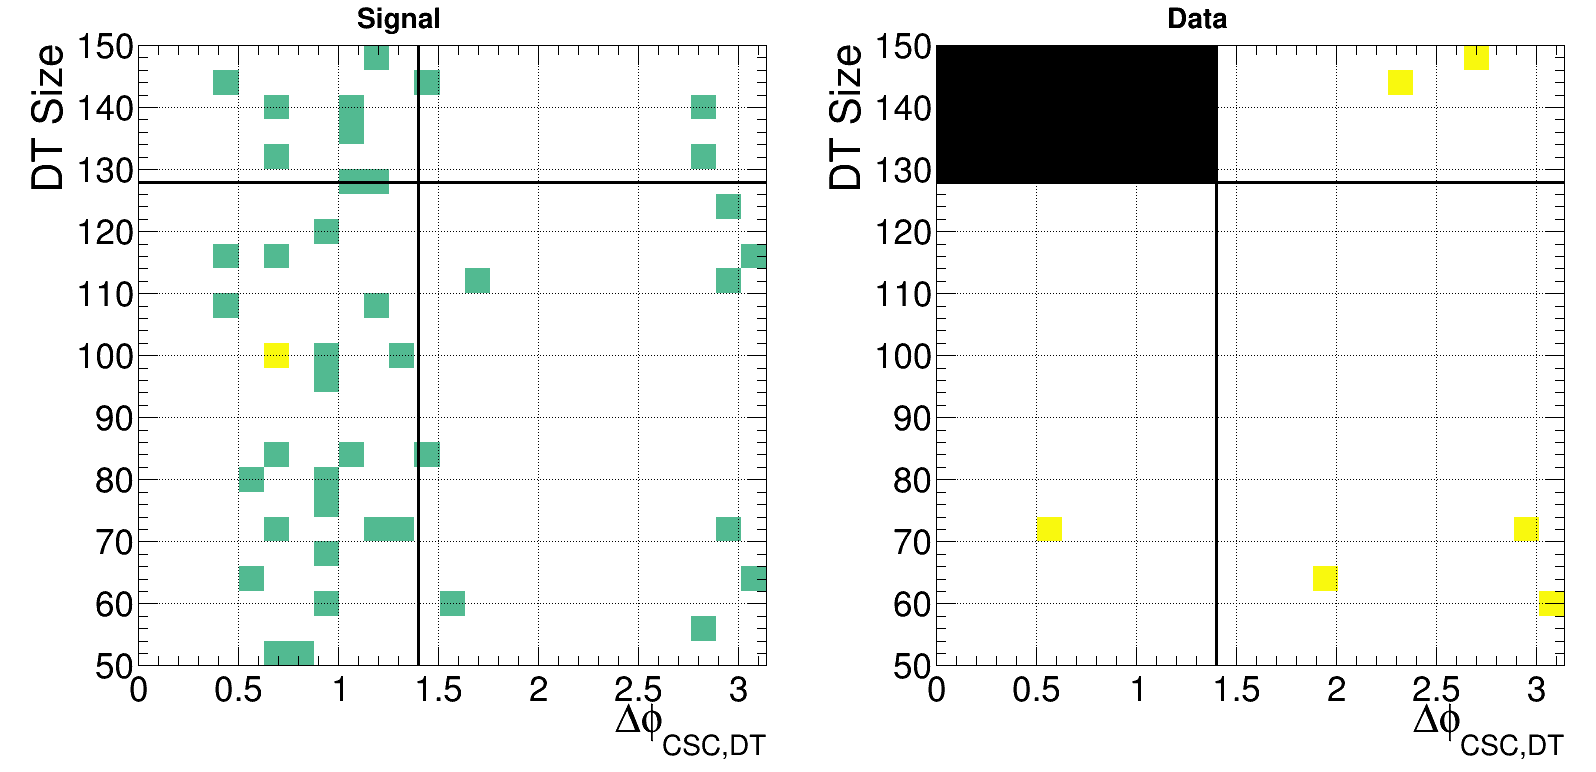

In [2]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)

dopt = ('col','box')[0]
nb = 25

form = ('',f';#Delta#phi_{{CSC,{SIZE_VAR.upper()}}};{SIZE_VAR.upper()} Size;count',nb,0,np.pi,nb,50,150)

dphi_line = TLine(ABCD_DPHI,50,ABCD_DPHI,150)
size_line = TLine(0,ABCD_SIZE,np.pi,ABCD_SIZE)
dphi_line.SetLineWidth(3)
size_line.SetLineWidth(3)

if 'high' in FN_R3:
    sr_box = TBox(0, ABCD_SIZE, ABCD_DPHI, 150)
else:# 'low' in FN_R3:
    sr_box = TBox(ABCD_DPHI, ABCD_SIZE, np.pi, 150)
sr_box.SetFillColor(rt.kBlack)

latex = TLatex()
latex.SetTextAlign(23)
latex.SetTextSize(0.04)

canvas.cd(1).SetGrid()
h_mc = rdfs['mc'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_mc.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Signal'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_MC else ''))

canvas.cd(2).SetGrid()
h_r3 = rdfs['r3'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_r3.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Data'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_R3 else ''))
if 'OOT' not in FN_R3:
    sr_box.Draw()

canvas.Draw()

In [3]:
"""

# SCS + DNN FROM LOO

## CSC-CSC, MET < 200:
In the entire sample:
    sig = 976.8133940775442
    bkg = 41.0
    s2b = 152.55262241626752

In the SR (predicted):
    sig = 443.40199830112397
    bkg = 0.8333333333333334 +/- 0.5485671571703195
    s2b = 485.72255302478584

## CSC-DT, MET < 75:
In the entire sample:
    sig = 903.7185142486123
    bkg = 45.0
    s2b = 134.7184020256673

In the SR (predicted):
    sig = 387.8257260344981
    bkg = 0.7096774193548387 +/- 0.5602260054067767
    s2b = 460.36905190785166

## CSC-DT, 150 < MET < 200:
In the entire sample:
    sig = 45.306743695618934
    bkg = 9.0
    s2b = 15.102247898539645

In the SR (predicted):
    sig = 19.93496722607233
    bkg = 1.3333333333333333 +/- 1.677740985615722
    s2b = 17.2641880413888


"""
def get_abcd(rdf):
    if 'high' in FN_MC:
        a = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')
        b = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        c = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        d = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')
    else: # if 'high' in FN_MC:
        a = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')
        b = rdf.Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        c = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {ABCD_SIZE})').Sum('weight')
        d = rdf.Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {ABCD_SIZE})').Sum('weight')

    return a, b, c, d

a_mc, b_mc, c_mc, d_mc = get_abcd(rdfs['mc'])
a_r3, b_r3, c_r3, d_r3 = get_abcd(rdfs['r3'])

a_mc, b_mc, c_mc, d_mc = a_mc.GetValue(), b_mc.GetValue(), c_mc.GetValue(), d_mc.GetValue()
a_r3, b_r3, c_r3, d_r3 = a_r3.GetValue(), b_r3.GetValue(), c_r3.GetValue(), d_r3.GetValue()

# if sum([x>0 for x in[a_mc,b_mc,c_mc,d_mc]]) != 4:
#     print('MC data is not complete!')
#     print(f'{a_mc=}, {b_mc=}, {c_mc=}, {d_mc=}')
#     raise
# if sum([x>0 for x in[b_r3,c_r3,d_r3]]) != 3:
#     print('R3 data is not complete!')
#     print(f'{b_r3=}, {c_r3=}, {d_r3=}')
#     raise

ap_mc = b_mc*d_mc/c_mc
ape_mc = ap_mc * np.sqrt(1/b_mc + 1/c_mc + 1/d_mc)

ap_r3 = b_r3*d_r3/c_r3
ape_r3 = ap_r3 * np.sqrt(1/b_r3 + 1/c_r3 + 1/d_r3)

print('In the entire sample:')
print(f'    sig = {a_mc+b_mc+c_mc+d_mc}')
print(f'    bkg = {a_r3+b_r3+c_r3+d_r3}')
print(f'    s2b = {(a_mc+b_mc+c_mc+d_mc)/np.sqrt(a_r3+b_r3+c_r3+d_r3)}')
print('')

print('In the SR (predicted):')
print(f'    sig = {a_mc}')
print(f'    bkg = {ap_r3} +/- {ape_r3}')
print(f'    s2b = {a_mc/np.sqrt(ap_r3)}')
print('')


# table
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    \\textbf{{{TAG_CATEGORY}}} & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
print(f'    Signal & {d_mc:.0f} & {c_mc:.0f} & {b_mc:.0f} & {a_mc:.0f} ($\pm$ {a_mc**0.5:.2f}) & {ap_mc:.2f} ($\pm$ {ape_mc:.2f}) \\\\')
if 'OOT' not in FN_R3:
    print(f'    Data & {d_r3:.0f} & {c_r3:.0f} & {b_r3:.0f} & -- & {ap_r3:.2f} ($\pm$ {ape_r3:.2f}) \\\\')
else:
    print(f'    Data & {d_r3:.0f} & {c_r3:.0f} & {b_r3:.0f} & {a_r3:.0f} ($\pm$ {a_r3**0.5:.2f}) & {ap_r3:.2f} ($\pm$ {ape_r3:.2f}) \\\\')
print(r'\end{tabular}')
print(r'\end{center}')

In the entire sample:
    sig = 45.306743695618934
    bkg = 9.0
    s2b = 15.102247898539645

In the SR (predicted):
    sig = 19.93496722607233
    bkg = 1.3333333333333333 +/- 1.677740985615722
    s2b = 17.26418804138884

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    \textbf{cscdt} & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    Signal & 5 & 5 & 14 & 20 ($\pm$ 4.46) & 14.50 ($\pm$ 9.58) \\
    Data & 4 & 3 & 1 & -- & 1.33 ($\pm$ 1.68) \\
\end{tabular}
\end{center}


In [4]:
for ct in CTAUS:
    # print(ct)
    rdf_mc, rdf_r3 = rdfs['mc'], rdfs['r3']
    if ct != CTAU:
        # data_mc['weight'] *= weight_calc(data_mc['cscCTau']+data_mc['dtCTau'], ct / 10, CTAU / 10)
        rdf_mc = rdf_mc.Redefine('weight', f'weight * ( 1.0 / ({ct/10}*{ct/10}) * TMath::Exp(-1.0 * tag_ctau / {ct/10}) / (TMath::Exp(-1.0 * tag_ctau / {CTAU/10}) / ({CTAU/10}*{CTAU/10})) )')

    a_mc, b_mc, c_mc, d_mc = get_abcd(rdf_mc)
    a_r3, b_r3, c_r3, d_r3 = get_abcd(rdf_r3)

    a_mc, b_mc, c_mc, d_mc = a_mc.GetValue(), b_mc.GetValue(), c_mc.GetValue(), d_mc.GetValue()
    a_r3, b_r3, c_r3, d_r3 = a_r3.GetValue(), b_r3.GetValue(), c_r3.GetValue(), d_r3.GetValue()
    
    ap_r3 = b_r3*d_r3/c_r3

    
    norm = 5 / (a_mc + b_mc + c_mc + d_mc)
    s2b = a_mc / (ap_r3**(1/2)) if ap_r3 else 1
    lv, le = 0 , 0
    # ct = 1000

    fdc = f'datacard_ct{ct:0>8.0f}_{TAG_CATEGORY}_{MET_CATEGORY}.txt'

    str_dc = f'''# norm {norm}
# CTAU {ct}
# ABCD_DPHI {ABCD_DPHI}
# ABCD_SIZE {ABCD_SIZE}
# ABCD_FLIP {MET_CATEGORY}
# S2B,LIMIT {s2b} {lv} {le}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {ap_r3:.3f} \t {b_r3:.3f} \t {c_r3:.3f} \t {d_r3:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {a_mc:.6e} \t 1 \t {b_mc:.6e} \t 1 \t {c_mc:.6e} \t 1 \t {d_mc:.6e} \t 1
------------------------------
single_A_{MET_CATEGORY} \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B_{MET_CATEGORY},single_C_{MET_CATEGORY},single_D_{MET_CATEGORY}
single_B_{MET_CATEGORY} \t rateParam \t chB \t bkg \t {b_r3:.3f} \t [0,{max(7, 7*b_r3):.3f}]
single_C_{MET_CATEGORY} \t rateParam \t chC \t bkg \t {c_r3:.3f} \t [0,{max(7, 7*c_r3):.3f}]
single_D_{MET_CATEGORY} \t rateParam \t chD \t bkg \t {d_r3:.3f} \t [0,{max(7, 7*d_r3):.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
'''
    with open(f'{DATA_DIR}/datacard_scan/{fdc}', 'w') as fdc:
        fdc.write(str_dc)

# Limit Plots

In [5]:
import pickle

# Christinas Run2 limits
r2_limit_tree = []
with open(f'{DATA_DIR}/BB_15_DTCSC.csv', "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        r2_limit_tree.append([float(x) for x in line.split(",")])

r2_limit_tree = np.array(r2_limit_tree, dtype=np.float32)
r2_limit_tree = r2_limit_tree[np.argsort(r2_limit_tree[:,0])]

R2_LIMIT = r2_limit_tree[r2_limit_tree[:,0] == CTAU/1000, -1][0]
# My Run3 limits
with open(f'{DATA_DIR}/limits.pkl', 'rb') as f:
    limit_dict = pickle.load(f)[TAG_CATEGORY]


idxs = np.argsort(np.array(limit_dict['comb']['ctau']))
for k, v in limit_dict.items():
    for k2, v2 in v.items():
        limit_dict[k][k2] = np.array(v2)[idxs]

In [6]:
ctaus = np.array(limit_dict['comb']['ctau'])

canvas = TCanvas('','',800,800)
canvas.SetLogx()
canvas.SetLogy()
canvas.SetGrid()

legend = TLegend(0.56, 0.14, 0.94, 0.38)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kWhite, 0)
legend.SetTextSize(0.04)
legend.SetMargin(0.2)
ii = 0
names = {'run2':'Run 2 (CSC-DT)','high' : '150 < ME_{T} < 200 GeV', 'low' : 'ME_{T} < 75 GeV', 'comb' : 'Run 3 Combined'}

print(r'\begin{center}')
print(r'\begin{tabular}{c|c|cc}')
print(r'    & ct=1m (\frac{limit}{run2}) & best ct & best limit (\frac{limit}{run2}) \\')
print(r'    \hline')

for il, name in enumerate(['run2', 'low']):#, 'high', 'comb']):
    if name in limit_dict:
        limits = np.array(limit_dict[name]['limit'])  #* 23/137#*23/(60*2) # # 
        limitELs = np.array(limit_dict[name]['2.5'])  #* 23/137#*23/(60*2) # # 
        limitEHs = np.array(limit_dict[name]['97.5']) # * 23/137#*23/(60*2) # # 

        _ctaus, _limits = ctaus/1000, limits
        _limitELs, _limitEHs = np.abs(_limits - limitELs), np.abs(limitEHs - _limits)
        
    else:
        _ctaus = r2_limit_tree[:, 0]
        _limits = r2_limit_tree[:, -1]
        _limitELs = np.abs(r2_limit_tree[:, 1] - _limits)
        _limitEHs = np.abs(r2_limit_tree[:, -2] - _limits)
    
    gr = TGraphAsymmErrors(len(_ctaus), _ctaus*1., _limits*1., _ctaus*0., _ctaus*0., _limitELs*1., _limitEHs*1.)\
    
    lm1 = np.min(_limits[_ctaus==1])
    lmb = np.min(_limits)
    ctb = _ctaus[_limits == lmb][0]
    r21 = np.min(r2_limit_tree[r2_limit_tree[:,0]==1,-1])
    r2b = np.min(r2_limit_tree[:,-1])

    print(f'    {name} & {lm1:.2e} ({lm1/r21:.1f}) & {ctb:.3f} & {lmb:.2e} ({lmb/r2b:.1f}) \\\\')
    gr.SetName(name)
    gr.SetName(names[name])
    gr.GetXaxis().SetTitle(r'c#tau [m]')
    gr.GetYaxis().SetTitle(r'95% CL upper limit on BR(H#rightarrow SS)')

    gr.SetMinimum(1e-4)
    gr.SetMaximum(1)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[il])
    
    gr.SetMarkerSize(1)
    gr.SetMarkerColor(SCL[il])
    gr.SetMarkerStyle(rt.kFullCircle)

    gr.SetFillColorAlpha(SCL[il], 0.3)

    gr.Draw(('' if ii else 'A ') + 'L3')
    ii += 1
    legend.AddEntry(gr, gr.GetName(), 'LF')
    gc.append(gr)
print(r'\end{tabular}')
print(r'\end{center}')


legend.Draw()
canvas.Draw()


\begin{center}
\begin{tabular}{c|c|cc}
    & ct=1m (\frac{limit}{run2}) & best ct & best limit (\frac{limit}{run2}) \\
    \hline
    run2 & 2.16e-03 (1.0) & 0.600 & 1.81e-03 (1.0) \\


TypeError: none of the 10 overloaded methods succeeded. Full details:
  TGraphAsymmErrors::TGraphAsymmErrors(const TVectorT<float>& vx, const TVectorT<float>& vy, const TVectorT<float>& vexl, const TVectorT<float>& vexh, const TVectorT<float>& veyl, const TVectorT<float>& veyh) =>
    TypeError: takes at most 6 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(const TVectorT<double>& vx, const TVectorT<double>& vy, const TVectorT<double>& vexl, const TVectorT<double>& vexh, const TVectorT<double>& veyl, const TVectorT<double>& veyh) =>
    TypeError: takes at most 6 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(const TGraphAsymmErrors& gr) =>
    TypeError: takes at most 1 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(const TH1* pass, const TH1* total, const char* option = "") =>
    TypeError: takes at most 3 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(const TH1* h) =>
    TypeError: takes at most 1 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors() =>
    TypeError: takes at most 0 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(int n) =>
    TypeError: takes at most 1 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(const char* filename, const char* format = "%lg %lg %lg %lg %lg %lg", const char* option = "") =>
    TypeError: takes at most 3 arguments (7 given)
  TGraphAsymmErrors::TGraphAsymmErrors(int n, const float* x, const float* y, const float* exl = nullptr, const float* exh = nullptr, const float* eyl = nullptr, const float* eyh = nullptr) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)
  TGraphAsymmErrors::TGraphAsymmErrors(int n, const double* x, const double* y, const double* exl = nullptr, const double* exh = nullptr, const double* eyl = nullptr, const double* eyh = nullptr) =>
    TypeError: could not convert argument 2 (could not convert argument to buffer or nullptr)

In [ ]:
f'{0.5/431:e}'

'1.160093e-03'